## Sequential Feature Selector
参考
http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

In this notebook, I try to execute SFS example.

## 背景
前に変数選択(feature selection)をまとめたが、その中のForward Selectionはsklearnでは実装されていなかった。
https://aotamasaki.hatenablog.com/entry/2018/04/18/201127

ググるとsklearnのissueで実装しろって突っ込まれてる。(2016年3月ってことはもう実装する気がない？)

https://github.com/scikit-learn/scikit-learn/issues/6545

そしたらRでやれって話なんですが、できるなら慣れたPythonでやりたい...

先程のissueの議論を読んで行ったところ、mlxtendというライブラリーが紹介されていた。

http://rasbt.github.io/mlxtend/

一言で言うとsklearnを楽に使って便利機能を追加するもの。どういうことができるかは下記の記事がまとめています。ほかの日本語記事はブログ投稿時点では見当たらなかった。

https://qiita.com/altescy/items/60a6def66f13267f6347

このmlxtendというライブラリーにはforward selectionを含むwrapper methodと呼ばれる手法が実装されていたので、使い方の勉強がてら、まとめることにした。ソースコードはコピペだが…

## Sequential Feature Selector
こちらのドキュメントを要約してまとめることにします。

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

### まず、forward selectionを行ってみる。
いきなりですが、Exampleをコピペしてforward selectionを行ってみる。
mlxtendでは`SequentialFeatureSelector()`の引数を調整することでforward selectionを行うことができる。

使うデータはiris。

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target
knn = KNeighborsClassifier(n_neighbors=4)
print('サンプル数',X.shape[0],'\t説明変数の数',X.shape[1])
print('特徴名(説明変数名)\n',iris.feature_names)
print('クラス [0,1,2]\n',iris.target_names)

サンプル数 150 	説明変数の数 4
特徴名(説明変数名)
 ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
クラス [0,1,2]
 ['setosa' 'versicolor' 'virginica']


では、forward selectionを行う。コードではSequentialFeatureSelectorの引数に、`forward=True`をセットすれば良い。

In [2]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sfs1 = SFS(knn, # 使う学習器
           k_features=3, #特徴をいくつまで選択するか
           forward=True, #Trueでforward selectionになる。Falseでback
           floating=False, #後に説明するが、forward selectionの亜種を行うためのもの。
           verbose=2, #実行時のlogをどれだけ詳しく表示するか
           scoring='accuracy', # 評価指標
           cv=5) #クロスバリデーション
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

sfs1 = sfs1.fit(X, y)
sfs1.subsets_

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2018-06-14 23:04:06] Features: 1/3 -- score: 0.96[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2018-06-14 23:04:06] Features: 2/3 -- score: 0.9666666666666668[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-06-14 23:04:06] Features: 3/3 -- score: 0.9533333333333334

{1: {'avg_score': 0.96,
  'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]),
  'feature_idx': (3,)},
 2: {'avg_score': 0.9666666666666668,
  'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.96666667, 1.        ]),
  'feature_idx': (2, 3)},
 3: {'avg_score': 0.9533333333333334,
  'cv_scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 0.96666667]),
  'feature_idx': (0, 2, 3)}}

In [3]:
print('最終的に選ばれた3つの特徴')
for i in sfs1.k_feature_idx_:
    print(i,'番目 ',iris.feature_names[i])

最終的に選ばれた3つの特徴
0 番目  sepal length (cm)
2 番目  petal length (cm)
3 番目  petal width (cm)


なんとこれで変数選択おしまい。なんて楽なんだ。

続いてどうやって選んでいるのか、中身に触れてく。
### sequential feature algorithms (SFAs)
`SequentialFeatureSelector()`には4つのアルゴリズムが含まれている。

1. Sequential Forward Selection (SFS)
2. Sequential Backward Selection (SBS)
3. Sequential Forward Floating Selection (SFFS)
4. Sequential Backward Floating Selection (SBFS)

である。今回は1つ目と3つ目のアルゴリズムにふれる。

#### 1. Sequential Forward Selection (SFS)
入力: 
$
Y = \left\{ y _ { 1 } , y _ { 2 } , \ldots , y _ { d } \right\}
$

$y_1, y_2...$は特徴(説明変数)である。Yはすべての説明変数の集合である。説明変数はdつあるとする。

出力:
$ X _ { k } = \left\{ x _ { j } | j = 1,2 , \dots , k ; x _ { j } \in Y \right\} $

つまり$X$は$Y$の部分集合である。ただし$k<d$。

アルゴリズム:

初めは、$ X _ { 0 } = \emptyset , k = 0 $から始める。(選ぶ特徴なし)

**step1**
$$ x ^ { + } = \arg_x \max J \left( X _ { k } + x \right) , \text { where } x \in Y - X _ { k } $$

Jは評価指標のこと。つまり取り込むことで評価が一番上がった特徴を$ x ^ { + } $としておく。

**step2**
$$ X _ { k + 1} = X _ { k } + x ^ { + } $$

取り込むことで評価が一番上がった特徴を用いることにする。

**step3**
$$ k = k+1$$
go to step1

step1~step3を繰り返す。
そして、kが我々の指定した数に到達したら、処理を終わらせる。
そのときの$ X _ { k }$が得られた特徴の集合である。

アニメーションに示すとこういうことである。**(ここにスライド挿入)**

#### 2. Sequential Backward Selection (SBS)
上記1. Sequential Forward Selection (SFS)では、特徴を追加していったが、これは、削除していくだけである。詳細は省く。

#### 3. Sequential Forward Floating Selection (SFFS)
上記1. Sequential Forward Selection (SFS)の亜種である。
アルゴリズムは取り込むことで評価が上がるものを含むところまで同じで、その後に削除すべき特徴があるか探す工程を追加している。

アルゴリズム：

初めは、$ X _ { 0 } = \emptyset , k = 0 $から始める。(選ぶ特徴なし)


**step1**
$$ x ^ { + } = \arg_x \max J \left( X _ { k } + x \right) , \text { where } x \in Y - X _ { k } $$

**step2**
$$ X _ { k + 1} = X _ { k } + x ^ { + } $$

**step3**
$$ k = k+1$$

ここまではおなじ

**step4**
$$ x ^ { - } = \arg_x \max J \left( X _ { k } - x \right) , \text { where } x \in X _ { k } $$

つまり、削除したときに最も性能がよかった特徴を覚えておく。

**step5**

$ if \ J \left( x _ { k } - x^{-} \right) > J \left( x _ { k } \right) $:

    go to step6
    
else:

    go to step1
    
変数を削除するときとしないときで、どちらのほうが評価が良いのか比較する。もし削除したほうが良いのなら、次のstepに進む。

**step6**
$$ X _ { k - 1} = X _ { k } - x ^ { - } $$

問題の特徴を集合から削除

**step7**
$$k = k-1$$
go to step1

kを更新して始めに戻る


#### 4. Sequential Backward Floating Selection (SBFS)
先の2. Sequential Backward Selection (SBS)と同じようなもの。3.Sequential Forward Floating Selection (SFFS)は特徴追加していったが、これは削除していくだけである。

### 選択手法の切り替え
先程4つのアルゴリズムを挙げたが、`SequentialFeatureSelector()`の引数を変えることで、どのアルゴリズムを使うか決めることができる。
`forward`が特徴を増やしていくのか減らしていくのかを決める。`=True`で0から初めて特徴を増やしていく。 `floating`で3.SFFSや4.SBFSを使うかを指定できる。`=False`で1.SFSや2.SBSのただ単に追加/削除していくアルゴリズムが実行される。


In [4]:
def namaegaomoitsukanai(c):
    print('\n\ncv=',c)
    # Sequential Forward Selection
    sfs = SFS(knn, 
              k_features=3, 
              forward=True, 
              floating=False, 
              scoring='accuracy',
              cv=c,
              n_jobs=-1)
    sfs = sfs.fit(X, y)

    print('\nSequential Forward Selection (k=3):')
    print(sfs.k_feature_idx_)
    print('CV Score:')
    print(sfs.k_score_)

    ###################################################

    # Sequential Backward Selection
    sbs = SFS(knn, 
              k_features=3, 
              forward=False, 
              floating=False, 
              scoring='accuracy',
              cv=c,
              n_jobs=-1)
    sbs = sbs.fit(X, y)

    print('\nSequential Backward Selection (k=3):')
    print(sbs.k_feature_idx_)
    print('CV Score:')
    print(sbs.k_score_)

    ###################################################

    # Sequential Forward Floating Selection
    sffs = SFS(knn, 
               k_features=3, 
               forward=True, 
               floating=True, 
               scoring='accuracy',
               cv=c,
               n_jobs=-1)
    sffs = sffs.fit(X, y)

    print('\nSequential Forward Floating Selection (k=3):')
    print(sffs.k_feature_idx_)
    print('CV Score:')
    print(sffs.k_score_)

    ###################################################

    # Sequential Backward Floating Selection
    sbfs = SFS(knn, 
               k_features=3, 
               forward=False, 
               floating=True, 
               scoring='accuracy',
               cv=c,
               n_jobs=-1)
    sbfs = sbfs.fit(X, y)

    print('\nSequential Backward Floating Selection (k=3):')
    print(sbfs.k_feature_idx_)
    print('CV Score:')
    print(sbfs.k_score_)
    ###################################################
    ###################################################

for c in [4, 5, 10]:
    namaegaomoitsukanai(c)



cv= 4

Sequential Forward Selection (k=3):
(1, 2, 3)
CV Score:
0.9727564102564104

Sequential Backward Selection (k=3):
(1, 2, 3)
CV Score:
0.9727564102564104

Sequential Forward Floating Selection (k=3):
(1, 2, 3)
CV Score:
0.9727564102564104

Sequential Backward Floating Selection (k=3):
(1, 2, 3)
CV Score:
0.9727564102564104


cv= 5

Sequential Forward Selection (k=3):
(0, 2, 3)
CV Score:
0.9533333333333334

Sequential Backward Selection (k=3):
(0, 1, 3)
CV Score:
0.9533333333333334

Sequential Forward Floating Selection (k=3):
(0, 2, 3)
CV Score:
0.9533333333333334

Sequential Backward Floating Selection (k=3):
(0, 1, 3)
CV Score:
0.9533333333333334


cv= 10

Sequential Forward Selection (k=3):
(0, 2, 3)
CV Score:
0.9666666666666666

Sequential Backward Selection (k=3):
(0, 2, 3)
CV Score:
0.9666666666666666

Sequential Forward Floating Selection (k=3):
(0, 2, 3)
CV Score:
0.9666666666666666

Sequential Backward Floating Selection (k=3):
(0, 2, 3)
CV Score:
0.9666666666666666


面白いことにCVを変えると選ばれている特徴が変わる。CVを多くしてる方がよい特徴を選択してると信じたいが…どうなんでしょう

### 他の便利機能
#### feature selectionしてるときの詳細
get_metric_dict()で詳細を取得してpandasに投げることでいろいろ見られます。

In [6]:
import pandas as pd
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,0.96,0.0320608,"[0.9666666666666667, 0.9666666666666667, 0.933...","(3,)",0.0249444,0.0124722
2,0.966667,0.0270963,"[0.9666666666666667, 0.9666666666666667, 0.933...","(2, 3)",0.0210819,0.0105409
3,0.953333,0.0209887,"[0.9666666666666667, 0.9666666666666667, 0.933...","(0, 2, 3)",0.0163299,0.00816497


#### 扱う特徴の数と性能のプロット
ひと目でわかる便利なやつが、簡単に可視化できる。便利すぎないか？？

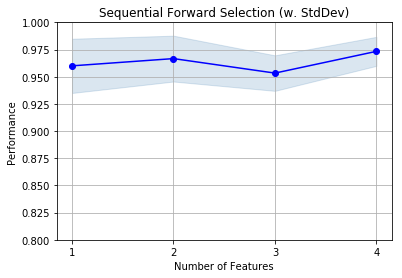

In [7]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

sfs = SFS(knn, 
          k_features=4, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)

sfs = sfs.fit(X, y)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

これを見る限りirisは全部の特徴をぶっこんだ方が良いかもしれない。

ここで思うのが、こんな図みて良い特徴の数を探すのがめんどくさい。それぐらい自動でやってくれ。やりましょう。
`k_features=(3, 10)`のように選ぶ特徴の数の範囲を指定することもできる。この場合、この範囲内で一番良い性能を示したものが`sfs(自分で作ったインスタンス).k_feature_idx_`に格納される。



こっから先は、ソースコードの実行はなしでいきます。
#### transform
sklearn同様、fransformですぐさまいらない変数を省くことができる。
```Python
X_train_sfs = sfs1.transform(X_train)
```
といった感じで使える。

#### GridSearch
sklearnのPipelineに対応している。そのおかげでGridserchができる。

```Python
sfs1 = SFS(estimator=knn, 
           k_features=3,
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=5)

pipe = Pipeline([('sfs', sfs1), 
                 ('knn', knn)])

param_grid = [
  {'sfs__k_features': [1, 2, 3, 4],
   'sfs__estimator__n_neighbors': [1, 2, 3, 4]}
  ]

gs = GridSearchCV(estimator=pipe, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=5,  
                  refit=False)

```
というようにすると、モデルのパラメータを変えたときに特徴をどれだけ使って予測するとどうなるのか簡単に書くことができる。

